In [1]:
import csv

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import nltk
import re
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import roc_curve ,roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import dill
import pickle
import os

from collections import Counter


#nltk.download('wordnet')
#https://stackoverflow.com/questions/37081597/merging-countvectorizer-in-scikit-learn-feature-extraction
# This is about combine multiple transformer.
#https://www.youtube.com/watch?v=bPYJi1E9xeM

In [2]:
#Techcrunch,Thenextweb 사이트의 App 과 hard 부문의 기사를 스크래핑한 각 파일을 불러온다. 그리고 label,text 리스트에 저장한다.
label_list = []
text_list = []

tnw_excel = pd.read_excel('TNW_apps3.xlsx')

for index,row in tnw_excel.iterrows():
    label_list.append('App')
    text_list.append(row['text'])

with open('Techcrunch_Apps.csv', 'r', encoding='utf-8',errors = "ignore") as crunch_app:
    fetch_row = csv.reader(crunch_app,delimiter=',')
    next(fetch_row,None)
    for row in fetch_row:
        label_list.append('App')
        text_list.append(row[2])

with open('TNW_apps2.csv', 'r', encoding='utf-8',errors = "ignore") as tnw_app:
    fetch_row = csv.reader(tnw_app,delimiter=',')
    next(fetch_row,None)
    for row in fetch_row:
        label_list.append('App')
        text_list.append(row[2])

with open('Techcrunch_hard.csv', 'r', encoding='utf-8',errors = "ignore") as crunch_hard:
    fetch_row = csv.reader(crunch_hard,delimiter=',')
    next(fetch_row,None)
    for row in fetch_row:
        label_list.append('Hard')
        text_list.append(row[2])
 
with open('TNW_hard2.csv', 'r', encoding='utf-8',errors = "ignore") as tnw_hard:
    fetch_row = csv.reader(tnw_hard,delimiter=',')
    next(fetch_row,None)
    for row in fetch_row:
        label_list.append('Hard')
        text_list.append(row[2])

In [3]:
print (len(label_list))

4003


In [4]:
Counter(label_list)

Counter({'App': 2003, 'Hard': 2000})

In [5]:
print (len(text_list))

4003


In [6]:
# 두 리스트를 합쳐 모델을 형성하기 위한 데이터프레임을 만든다. 
article_dataframe = pd.DataFrame(
                    {
                        'label' : label_list,
                        'text' : text_list
                    })

article_dataframe.label.unique()

array(['App', 'Hard'], dtype=object)

In [7]:
article_dataframe.head()

,label,text
0,App,Google today announced it was adding a Q&A fea...
1,App,A tweet sent by former US President Barack Oba...
2,App,The Facebook birthday message has practically ...
3,App,Google wants to save you from the sniffles. To...
4,App,Tesla already has a pretty sleek configuration...


In [8]:
len(article_dataframe[article_dataframe.label == 'App'])

2003

In [9]:
len(article_dataframe[article_dataframe.label == 'Hard'])

2000

In [10]:
#데이터를 훈련데이터와 테스트데이터로 나눌 때 label별 데이터가 균등하게 분포할 수 있게 데이터프레임의 행을 섞어 준다.
#article_dataframe = article_dataframe.sample (frac = 1).reset_index(drop =True)

In [11]:
article_dataframe.head()

,label,text
0,App,Google today announced it was adding a Q&A fea...
1,App,A tweet sent by former US President Barack Oba...
2,App,The Facebook birthday message has practically ...
3,App,Google wants to save you from the sniffles. To...
4,App,Tesla already has a pretty sleek configuration...


In [12]:
# 텍스트와 클래스 데이터를 나눈다.
# 데이터를 무작위로 섞어주는 과정이 필요하다.
df_x = article_dataframe['text']
df_y = article_dataframe['label']

In [13]:
df_y

0        App
1        App
2        App
3        App
4        App
5        App
6        App
7        App
8        App
9        App
10       App
11       App
12       App
13       App
14       App
15       App
16       App
17       App
18       App
19       App
20       App
21       App
22       App
23       App
24       App
25       App
26       App
27       App
28       App
29       App
        ... 
3973    Hard
3974    Hard
3975    Hard
3976    Hard
3977    Hard
3978    Hard
3979    Hard
3980    Hard
3981    Hard
3982    Hard
3983    Hard
3984    Hard
3985    Hard
3986    Hard
3987    Hard
3988    Hard
3989    Hard
3990    Hard
3991    Hard
3992    Hard
3993    Hard
3994    Hard
3995    Hard
3996    Hard
3997    Hard
3998    Hard
3999    Hard
4000    Hard
4001    Hard
4002    Hard
Name: label, Length: 4003, dtype: object

In [14]:
x_traintfidf_vect = TfidfVectorizer(stop_words='english')

In [15]:
x_train, x_test, y_train, y_test = train_test_split(df_x,df_y,test_size=0.2, train_size = 0.8,random_state = 0,shuffle=True)

In [16]:
x_traintfidf = x_traintfidf_vect.fit_transform(x_train) 

In [17]:
# 512 doc and 15948 어휘를 갖는 tf-idf 형성
x_traintfidf

<3202x30716 sparse matrix of type '<class 'numpy.float64'>'
	with 442878 stored elements in Compressed Sparse Row format>

In [18]:
a = x_traintfidf.toarray()

In [19]:
a[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [20]:
len(a[0])

30716

In [21]:
x_traintfidf_vect.inverse_transform(a[0])

[array(['20', '2000', '260', '30', '3000', '40', 'actually', 'adjust',
        'adjustments', 'afforded', 'allow', 'alot', 'amateur', 'app',
        'apply', 'apps', 'arcade', 'assigns', 'average', 'balance',
        'batches', 'benefits', 'best', 'big', 'bunch', 'buttons', 'cheap',
        'chunk', 'colors', 'comes', 'common', 'companion', 'competing',
        'comprised', 'considering', 'contrast', 'controls', 'convinced',
        'curate', 'custom', 'customizable', 'cut', 'design', 'designed',
        'device', 'devices', 'did', 'disappointingly', 'doesn', 'don',
        'easy', 'edit', 'editing', 'effective', 'eighty', 'exposure',
        'extra', 'extreme', 'fashion', 'faster', 'feel', 'feels',
        'flexibility', 'flimsy', 'fond', 'function', 'functions',
        'getting', 'giant', 'goes', 'good', 'got', 'great', 'half',
        'hardware', 'highlights', 'hire', 'hope', 'hours', 'huge', 'image',
        'including', 'individual', 'inflexible', 'intuition', 'ironically',
     

In [23]:
x_train.iloc[0]

'When people hire a photographer, they usually don’t realize how much work goes into the editing process. If I spend eight hours shooting a wedding, it will often take me eighty hours to edit the photos.\nLoupedeck, a hardware device that assigns physical controls to almost all of Lightroom’s editing functions, is designed to significantly reduce that editing time.\nUnlike most competing devices that work with multiple apps, such as the modular Palette, the Loupedeck only works with Lightroom. It’s supremely niche, and $260 is a lot of money to pay for such an inflexible device.\nBut it’s that extreme niche that makes it so effective. For big jobs, it nearly cut my editing time in half. As they say, time is money.\n\nThe module is comprised of several controls mapped to almost every function you’ll regularly use in Lightroom. Image rotation is done via a giant knob, your usual exposure parameters are mapped to a bunch of smaller ones, and while a myriad of common functions have their o

In [24]:
mnb = MultinomialNB()

In [25]:
mnb.fit(x_traintfidf,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [26]:
x_testcv = x_traintfidf_vect.transform(x_test)

In [27]:
pred = mnb.predict(x_testcv)

In [28]:
pred

array(['Hard', 'App', 'Hard', 'Hard', 'App', 'App', 'App', 'Hard', 'App',
       'App', 'Hard', 'App', 'Hard', 'Hard', 'Hard', 'App', 'Hard',
       'Hard', 'Hard', 'Hard', 'Hard', 'App', 'App', 'App', 'App', 'App',
       'Hard', 'Hard', 'Hard', 'Hard', 'App', 'App', 'App', 'Hard',
       'Hard', 'App', 'App', 'App', 'Hard', 'Hard', 'Hard', 'App', 'App',
       'Hard', 'Hard', 'Hard', 'Hard', 'App', 'Hard', 'App', 'App', 'App',
       'Hard', 'App', 'App', 'App', 'App', 'Hard', 'Hard', 'Hard', 'App',
       'Hard', 'App', 'Hard', 'App', 'Hard', 'App', 'App', 'App', 'App',
       'Hard', 'App', 'App', 'Hard', 'App', 'Hard', 'Hard', 'Hard',
       'Hard', 'Hard', 'App', 'Hard', 'Hard', 'Hard', 'Hard', 'App',
       'App', 'Hard', 'App', 'App', 'Hard', 'Hard', 'Hard', 'App', 'App',
       'App', 'Hard', 'App', 'Hard', 'App', 'App', 'Hard', 'Hard', 'Hard',
       'Hard', 'App', 'App', 'App', 'App', 'App', 'App', 'App', 'Hard',
       'Hard', 'Hard', 'App', 'App', 'App', 'Hard', 'App', 'Ha

In [29]:
actual = np.array(y_test)

In [30]:
actual

array(['Hard', 'App', 'Hard', 'Hard', 'App', 'App', 'App', 'App', 'App',
       'App', 'Hard', 'App', 'Hard', 'Hard', 'Hard', 'App', 'Hard',
       'Hard', 'Hard', 'Hard', 'Hard', 'App', 'App', 'App', 'App', 'App',
       'Hard', 'Hard', 'Hard', 'Hard', 'App', 'App', 'App', 'Hard', 'App',
       'App', 'App', 'Hard', 'App', 'Hard', 'Hard', 'App', 'Hard', 'Hard',
       'Hard', 'Hard', 'Hard', 'App', 'Hard', 'App', 'App', 'App', 'Hard',
       'App', 'App', 'App', 'App', 'Hard', 'Hard', 'Hard', 'App', 'Hard',
       'App', 'Hard', 'App', 'Hard', 'App', 'App', 'App', 'App', 'Hard',
       'App', 'App', 'Hard', 'App', 'Hard', 'Hard', 'Hard', 'App', 'Hard',
       'App', 'App', 'Hard', 'Hard', 'Hard', 'App', 'App', 'App', 'App',
       'App', 'Hard', 'Hard', 'Hard', 'Hard', 'App', 'App', 'Hard', 'App',
       'Hard', 'App', 'Hard', 'Hard', 'Hard', 'Hard', 'Hard', 'App',
       'App', 'App', 'App', 'App', 'App', 'App', 'App', 'Hard', 'Hard',
       'App', 'App', 'App', 'Hard', 'App', 'Hard'

In [31]:
count = 0
for i in range(len(pred)):
    if pred[i] == actual[i]:
        count = count + 1

In [32]:
count

739

In [33]:
len(pred)

801

In [34]:
count / len(pred)

0.9225967540574282

In [35]:
bi_y = []
for ele in df_y:
    if ele == 'App':
        bi_y.append(1)
    else :
        bi_y.append(0)
bi_y = pd.Series(bi_y)
bi_y
# app = 1 , hard = 0

0       1
1       1
2       1
3       1
4       1
5       1
6       1
7       1
8       1
9       1
10      1
11      1
12      1
13      1
14      1
15      1
16      1
17      1
18      1
19      1
20      1
21      1
22      1
23      1
24      1
25      1
26      1
27      1
28      1
29      1
       ..
3973    0
3974    0
3975    0
3976    0
3977    0
3978    0
3979    0
3980    0
3981    0
3982    0
3983    0
3984    0
3985    0
3986    0
3987    0
3988    0
3989    0
3990    0
3991    0
3992    0
3993    0
3994    0
3995    0
3996    0
3997    0
3998    0
3999    0
4000    0
4001    0
4002    0
Length: 4003, dtype: int64

In [36]:
# custom tokenizer를 이용한 분류기를 구현한 파이프 라인
vect_tokenizer = TfidfVectorizer().build_analyzer()
lemmatizer = WordNetLemmatizer()

def custom_tokenizer (doc) :
    tokens = vect_tokenizer(doc)
    return [lemmatizer.lemmatize(token) for token in tokens]

def create_model ():
    tfidf = TfidfVectorizer(tokenizer = custom_tokenizer,stop_words = "english")
    clf = MultinomialNB()
    pipeline = Pipeline([('vect',tfidf), ('clf',clf)])
    return pipeline

0.928	0.003	0.980	0.004


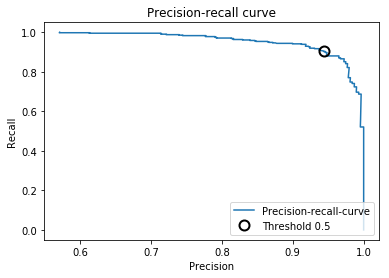

In [37]:
# 교차검증 - 일반화 성능 측정
k_fold = KFold (n_splits = 5, random_state = 0, shuffle = True)

scores = []
pr_scores = []

for train_index, test_index in k_fold.split(df_x):
    
    X_train, X_test = df_x[train_index], df_x[test_index]
    Y_train, Y_test = bi_y[train_index], bi_y[test_index]
    
    clf = create_model()
    clf.fit(X_train,Y_train)
    Y_pred = clf.predict(X_test)
    
    train_score = clf.score(X_train,Y_train)
    test_score = clf.score(X_test,Y_test)
    
    scores.append(test_score)
    proba = clf.predict_proba(X_test)
    
    # proba[:,1] -> slicing  array , take all rows but keeping the second col
    # There are probabilities of hard in '0' column
    # There are probabilities of app in '1' column 
    precision, recall, pr_thresholds = precision_recall_curve(Y_test,proba[:,1])
    pr_scores.append(auc(recall,precision))
    
summary = (np.mean(scores),np.std(scores),
        np.mean(pr_scores),np.std(pr_scores))

# mean precision, std , mean auc and std 
print("%.3f\t%.3f\t%.3f\t%.3f"%summary)

close_default = np.argmin(np.abs(pr_thresholds - 0.5))

plt.plot(precision,recall,label = "Precision-recall-curve")
plt.plot(precision[close_default],recall[close_default],'o',markersize=10,label="Threshold 0.5",fillstyle ="none",c= "k",mew = 2)
plt.title('Precision-recall curve')
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc = 'lower right')
plt.show()
# 교차검증을 수행하여 얻은 precision 의 평균 값은 91.6 , auc 평균 98% - 1에 가까울 수록 좋은 것 즉 recall 과 precision 둘다 높은 것
# Threshold 값은 50%와 제일 가까운 값을 표시한 것

In [38]:
# 그리드 서치를 이용한 최적 매개변수 탐색 - 정확도를 기준으로 판단
#AUC는 불균형한 데이터를 평가할 때 유용하므로 정확도를 기준으로 판단한다. - grid search의 기본 설정값
# grid search 내에서 데이터가 다시 훈련데이터와 검증데이터로 나뉜다. -> 훈련데이터를 모델 검증을 위해 중복 사용하는 것을 방지하기 위해

X_train, X_test, Y_train, Y_test = train_test_split(df_x,df_y=="App",test_size = 0.2, random_state = 0,shuffle = 'True')

def grid_search_model (clf_factory,X,Y):
        
    param_grid = dict(vect__ngram_range = [(1,1), (1,2), (1,3)]#,
#                    vect__min_df = [1,2],
#                    vect__use_idf=[False,True],
#                    vect__sublinear_tf = [False,True],
                     )

    grid_search = GridSearchCV(clf_factory(),
                               param_grid = param_grid,
                               cv = 5,
                               verbose = 5,
                               return_train_score=True)
    
    grid_search.fit(X_train,Y_train)    
    return grid_search

In [39]:
# gridsearch
grid = grid_search_model(create_model,X_train,Y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] vect__ngram_range=(1, 1) ........................................
[CV]  vect__ngram_range=(1, 1), score=0.9282371294851794, total=   5.0s
[CV] vect__ngram_range=(1, 1) ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.1s remaining:    0.0s


[CV]  vect__ngram_range=(1, 1), score=0.9453978159126365, total=   5.3s
[CV] vect__ngram_range=(1, 1) ........................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.9s remaining:    0.0s


[CV] ........ vect__ngram_range=(1, 1), score=0.9140625, total=   5.6s
[CV] vect__ngram_range=(1, 1) ........................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.8s remaining:    0.0s


[CV] ............ vect__ngram_range=(1, 1), score=0.925, total=   5.0s
[CV] vect__ngram_range=(1, 1) ........................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   38.0s remaining:    0.0s


[CV] ............ vect__ngram_range=(1, 1), score=0.925, total=   5.4s
[CV] vect__ngram_range=(1, 2) ........................................
[CV]  vect__ngram_range=(1, 2), score=0.9282371294851794, total=   7.1s
[CV] vect__ngram_range=(1, 2) ........................................
[CV]  vect__ngram_range=(1, 2), score=0.9407176287051482, total=   7.0s
[CV] vect__ngram_range=(1, 2) ........................................
[CV] ........ vect__ngram_range=(1, 2), score=0.9109375, total=   7.2s
[CV] vect__ngram_range=(1, 2) ........................................
[CV] ............ vect__ngram_range=(1, 2), score=0.925, total=   7.6s
[CV] vect__ngram_range=(1, 2) ........................................
[CV] ......... vect__ngram_range=(1, 2), score=0.921875, total=   7.4s
[CV] vect__ngram_range=(1, 3) ........................................
[CV]  vect__ngram_range=(1, 3), score=0.9266770670826833, total=  10.6s
[CV] vect__ngram_range=(1, 3) ........................................
[CV

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  3.1min finished


In [40]:
#최적의 매개변수
grid.best_params_

{'vect__ngram_range': (1, 1)}

In [41]:
# 최상의 교차 검증 점수 (정확도)
grid.best_score_

0.9275452841973766

In [42]:
#테스트 세트 AUC
roc_auc_score(Y_test,grid.predict_proba(X_test)[:,1])

0.9793600009978546

In [43]:
#테스트 세트 정확도
grid.score(X_test,Y_test)

0.9250936329588015

In [44]:
results = pd.DataFrame(grid.cv_results_)
display(results)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_vect__ngram_range,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,4.283114,1.077716,0.927545,0.956823,"(1, 1)","{'vect__ngram_range': (1, 1)}",1,0.928237,0.957048,0.945398,...,0.914062,0.960578,0.925000,0.957065,0.925000,0.957455,0.183053,0.097642,0.010140,0.002762
1,6.171309,1.189548,0.925359,0.978841,"(1, 2)","{'vect__ngram_range': (1, 2)}",2,0.928237,0.979305,0.940718,...,0.910937,0.981655,0.925000,0.977752,0.921875,0.979313,0.183172,0.063486,0.009639,0.001823
2,8.725202,1.366694,0.924110,0.987196,"(1, 3)","{'vect__ngram_range': (1, 3)}",3,0.926677,0.988676,0.940718,...,0.910937,0.988290,0.923438,0.985948,0.918750,0.987119,0.347244,0.108534,0.009851,0.001142


In [45]:
# 최적매개변수를 지닌 vect를 추출
best_vector=grid.best_estimator_.named_steps["vect"]
best_vector

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function custom_tokenizer at 0x0000020EF6550510>,
        use_idf=True, vocabulary=None)

In [46]:
# 최적매개변수를 통해 산출된 분류기 추출
best_classifier = grid.best_estimator_.named_steps["clf"]
best_classifier

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [47]:
#scipy sparse matrix 참고하기 
X_train_vect = best_vector.transform(X_train)
max_value = X_train_vect.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
feature_names = np.array(best_vector.get_feature_names())
print("tfidf가 가장 낮은 특성 : \n{}".format(feature_names[sorted_by_tfidf[:50]]))
print("tfidf가 가장 높은 특성 : \n{}".format(feature_names[sorted_by_tfidf[-50:]]))

tfidf가 가장 낮은 특성 : 
['7012' 'rework' 'reys' 'holmdel' 'batterydr' '5lbs' 'dachshund' '20lbs'
 'microbus' 'scamsdont' 'cyclist' 'v100' 'congratulate' 'riva' '12nffn'
 'devolved' 'arrington' 'zf' 'learner' 'holodeck' 'cheered' 'drivethe'
 'drivernot' '2626' 'dumpling' 'tensor' 'maxq' 'wiki' 'vehiclelsjensen'
 'lincoln' 'lifethis' 'darrells' 'pegasus' 'meicos' 'infomercial'
 'unsolvable' 'jogged' 'miniatx' 'geforce3' 'routinehe' 'mkz'
 'iso_26262but' 'nj' 'themeand' 'somehowthank' 'breathless' 'vws' 'tflops'
 'hokey' 'aiand']
tfidf가 가장 높은 특성 : 
['magsafe' 'pebble' 'bag' 'paypal' 'cock' 'shuttle' 'vlc' 'pinterest'
 'font' 'ad' 'genie' 'backup' 'xz2' 'linkedin' 'vero' 'hoverseat' 'skype'
 'flash' 'karhoo' 'colibri' 'netatmo' 'gopro' 'pixie' 'pixelmator'
 'oneplus' 'blizzard' 'skill' 'pollen' 'revolv' 'watermark' 'lego' 'roku'
 'nova' 'lifestage' 'digit' 'fart' 'launcher' 'cabot' 'foursquare' 'viber'
 'snip' 'plex' 'conf' 'bike' 'brightness' 'pillow' 'tampon' 'airtame'
 'ipod' 'vine']


In [48]:
# 분류기 object를 저장
# file pointer에 의해 dump는 이어서 쓰게 되어 있다. 
dest = os.path.join('classifier','pkl_object')
if not os.path.exists(dest):
    os.makedirs(dest)

f = open(os.path.join(dest,'classifier2.pkl'),'wb')
pickle.dump(best_classifier,f,protocol = 4)
f.close()

In [50]:
from sklearn.externals import joblib
# vectorizer object를 저장
'''
class customvect :
    def __init__(self,vect,custom_tokenizer):
        self.vect = vect
        self.custom_tokenizer = custom_tokenizer

obj = customvect(best_vector,custom_tokenizer)
'''

dest = os.path.join('classifier','pkl_vect')

if not os.path.exists(dest):
    os.makedirs(dest)

f =  open(os.path.join(dest,'vect2.pkl'),'wb')
pickle.dump(custom_tokenizer,f,protocol = 4)
pickle.dump(best_vector,f,protocol = 4)
f.close()

# load 파일에서 custom vect 에 접근할 수 없다는 에러가 뜸